<a href="https://colab.research.google.com/github/aditeyabaral/kepler-exoplanet-analysis/blob/master/src/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import re

# Initialising libraires

In [2]:
pp = pprint.PrettyPrinter(indent = 3)

# Loading DataFrame

[Dataset URL](https://www.kaggle.com/nasa/kepler-exoplanet-search-results)<br>
[Link to Metadata](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)<br>
[Column Name Metadata](https://exoplanetarchive.ipac.caltech.edu/docs/API_keplerstellar_columns.html)

In [3]:
df = pd.read_csv("kepler-data.csv")
print(df.shape)
df.head()

(9564, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Counting NaN Values

In [4]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}

In [5]:
pp.pprint(nan_columns)

{  'kepler_name': 7270,
   'koi_depth': 363,
   'koi_depth_err1': 454,
   'koi_depth_err2': 454,
   'koi_duration_err1': 454,
   'koi_duration_err2': 454,
   'koi_impact': 363,
   'koi_impact_err1': 454,
   'koi_impact_err2': 454,
   'koi_insol': 321,
   'koi_insol_err1': 321,
   'koi_insol_err2': 321,
   'koi_kepmag': 1,
   'koi_model_snr': 363,
   'koi_period_err1': 454,
   'koi_period_err2': 454,
   'koi_prad': 363,
   'koi_prad_err1': 363,
   'koi_prad_err2': 363,
   'koi_score': 1510,
   'koi_slogg': 363,
   'koi_slogg_err1': 468,
   'koi_slogg_err2': 468,
   'koi_srad': 363,
   'koi_srad_err1': 468,
   'koi_srad_err2': 468,
   'koi_steff': 363,
   'koi_steff_err1': 468,
   'koi_steff_err2': 483,
   'koi_tce_delivname': 346,
   'koi_tce_plnt_num': 346,
   'koi_teq': 363,
   'koi_teq_err1': 9564,
   'koi_teq_err2': 9564,
   'koi_time0bk_err1': 454,
   'koi_time0bk_err2': 454}


We notice that **all the values** in 2 columns are NaN:
* koi_teq_err1
* koi_teq_err2

These columns are the associated errors in estimating the equilibrium temperatures of a exoplanet, and are assumed to have 0 or no error.

These attributes correspond to the error in estimating the equilibrium temperature of a planet. Since we cannot approximate their values, we can drop them.

In [6]:
df.drop(columns = ["koi_teq_err1", "koi_teq_err2"], inplace = True)

# Replacing NaN Values

There are two broad types of NaN values present.
* NaN in Error Values - These include the positive and negative error in estimating attributes
* NaN in Measurable Attributes - These include missing values in measuring attributes 

## Replacing NaN in Error Values

### Finding Error Attributes with NaN

In [7]:
missing_error_attribute_names = [attr for attr in df.columns if "err" in attr]
pp.pprint(missing_error_attribute_names)

[  'koi_period_err1',
   'koi_period_err2',
   'koi_time0bk_err1',
   'koi_time0bk_err2',
   'koi_impact_err1',
   'koi_impact_err2',
   'koi_duration_err1',
   'koi_duration_err2',
   'koi_depth_err1',
   'koi_depth_err2',
   'koi_prad_err1',
   'koi_prad_err2',
   'koi_insol_err1',
   'koi_insol_err2',
   'koi_steff_err1',
   'koi_steff_err2',
   'koi_slogg_err1',
   'koi_slogg_err2',
   'koi_srad_err1',
   'koi_srad_err2']


Since these are positive and negative error measures for the corresponding attributes, we can do either of the following 
* Replace with the mean or median of the attribute errors
* Replace with a default value = 0

We can also take a look at the percentage error in the column and error associated with the column

### Finding Error Attribute Means and Medians

Let us first extract a slice of the dataset that contains the error attributes

In [8]:
missing_error_values_df = df[missing_error_attribute_names].copy()
print(missing_error_values_df.shape)
missing_error_values_df.head()

(9564, 20)


,koi_period_err1,koi_period_err2,koi_time0bk_err1,koi_time0bk_err2,koi_impact_err1,koi_impact_err2,koi_duration_err1,koi_duration_err2,koi_depth_err1,koi_depth_err2,koi_prad_err1,koi_prad_err2,koi_insol_err1,koi_insol_err2,koi_steff_err1,koi_steff_err2,koi_slogg_err1,koi_slogg_err2,koi_srad_err1,koi_srad_err2
0,2.775000e-05,-2.775000e-05,0.002160,-0.002160,0.318,-0.146,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,29.45,-16.65,81.0,-81.0,0.064,-0.096,0.105,-0.061
1,2.479000e-04,-2.479000e-04,0.003520,-0.003520,0.059,-0.443,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,2.87,-1.62,81.0,-81.0,0.064,-0.096,0.105,-0.061
2,1.494000e-05,-1.494000e-05,0.000581,-0.000581,5.126,-0.077,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,31.04,-10.49,158.0,-176.0,0.044,-0.176,0.233,-0.078
3,2.630000e-07,-2.630000e-07,0.000115,-0.000115,0.115,-0.092,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,668.95,-230.35,157.0,-174.0,0.053,-0.168,0.201,-0.067
4,3.761000e-06,-3.761000e-06,0.001130,-0.001130,0.235,-0.478,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,874.33,-314.24,169.0,-211.0,0.070,-0.210,0.334,-0.133


We can now find the mean and median of the remaining columns

In [9]:
error_attribute_means = np.nanmean(missing_error_values_df.values, axis=0)
error_attribute_means

array([ 2.14786371e-03, -2.14786371e-03,  9.93256054e-03, -9.93256054e-03,
        1.95986060e+00, -3.32557464e-01,  3.39941514e-01, -3.39941514e-01,
        1.23197563e+02, -1.23197563e+02,  1.76576839e+01, -3.30233138e+01,
        3.75069791e+03, -4.04352237e+03,  1.44635554e+02, -1.62265059e+02,
        1.20737907e-01, -1.43160510e-01,  3.62292216e-01, -3.94805959e-01])

In [10]:
error_attribute_medians = np.nanmedian(missing_error_values_df.values, axis=0)
error_attribute_medians

array([ 3.5205e-05, -3.5205e-05,  4.1300e-03, -4.1300e-03,  1.9300e-01,
       -2.0700e-01,  1.4200e-01, -1.4200e-01,  2.0750e+01, -2.0750e+01,
        5.2000e-01, -3.0000e-01,  7.2830e+01, -4.0260e+01,  1.5700e+02,
       -1.6000e+02,  7.0000e-02, -1.2800e-01,  2.5100e-01, -1.1100e-01])

There seems to be some difference in the median and mean values, suggesting skewed data for attributes. We might need to plot each and decide when we can take median and when we can take mean

## Replacing NaN in Orbital Period

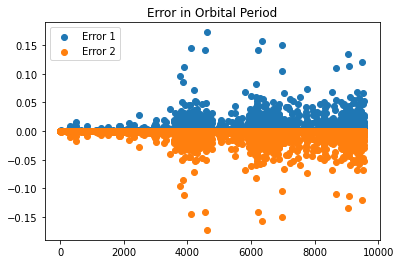

In [11]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_period_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_period_err2"].values, label = "Error 2")
plt.axvline(x = missing_error_values_df["koi_period_err1"].values.mean(), color = "red")
plt.title("Error in Orbital Period")
plt.legend()

### Viewing Frequency Distribution

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


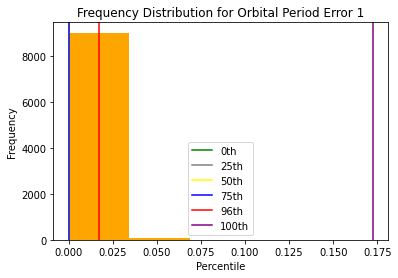

In [12]:
plt.hist(missing_error_values_df["koi_period_err1"].values, bins=5, color = "orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 25), color = "grey", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 75), color = "blue", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 96), color = "red", label = "96th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [13]:
df["koi_period_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 96), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


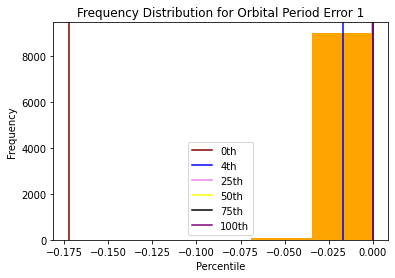

In [14]:
plt.hist(missing_error_values_df["koi_period_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 0), color = "maroon", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 4), color = "blue", label = "4th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 25), color = "violet", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [15]:
df["koi_period_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 5), inplace = True)

## Replacing NaN in Transit Epoch

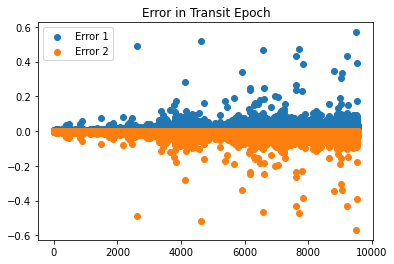

In [16]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_time0bk_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_time0bk_err2"].values, label = "Error 2")
plt.title("Error in Transit Epoch")
plt.legend()

### Viewing Frequency Distribution

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


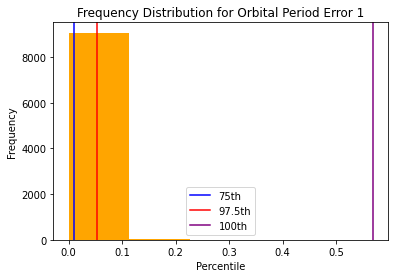

In [17]:
plt.hist(missing_error_values_df["koi_time0bk_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err1"].values, 75), color = "blue", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err1"].values, 97.5), color = "red", label = "97.5th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [18]:
df["koi_time0bk_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_time0bk_err1"].values, 97.5), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


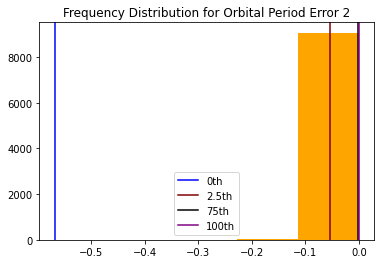

In [19]:
plt.hist(missing_error_values_df["koi_time0bk_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 2.5), color = "maroon", label = "2.5th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 2")
plt.legend()
plt.show()

In [20]:
df["koi_time0bk_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 2.5), inplace = True)

## Replacing NaN in Impact Parameter

### Viewing Frequency Distribution

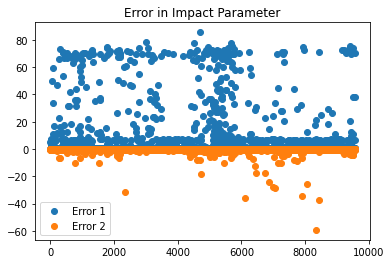

In [21]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_impact_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_impact_err2"].values, label = "Error 2")
plt.title("Error in Impact Parameter")
plt.legend()

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


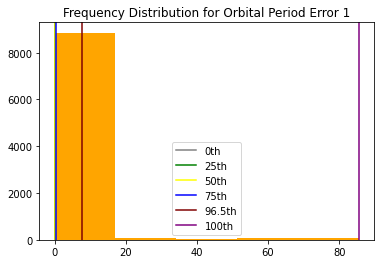

In [22]:
plt.hist(missing_error_values_df["koi_impact_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 0), color = "grey", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 25), color = "green", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 75), color = "blue", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 96.5), color = "maroon", label = "96.5th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [23]:
df["koi_impact_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 96.5), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


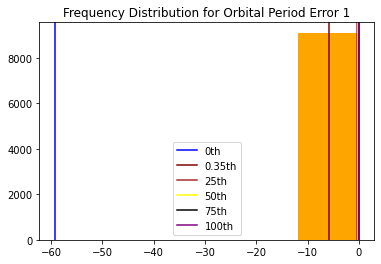

In [24]:
plt.hist(missing_error_values_df["koi_impact_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 0.35), color = "maroon", label = "0.35th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 25), color = "brown", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [25]:
df["koi_impact_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 0.35), inplace = True)

## Replacing NaN in Transit Duration

### Viewing Frequency Distribution

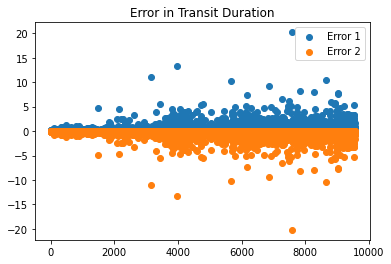

In [26]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_duration_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_duration_err2"].values, label = "Error 2")
plt.title("Error in Transit Duration")
plt.legend()

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


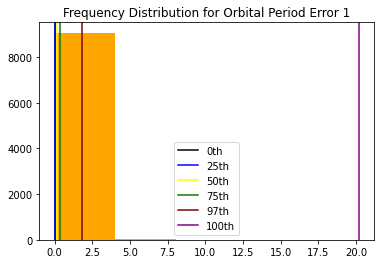

In [27]:
plt.hist(missing_error_values_df["koi_duration_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 0), color = "black", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 75), color = "green", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 97), color = "maroon", label = "97th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [28]:
df["koi_duration_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 97), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


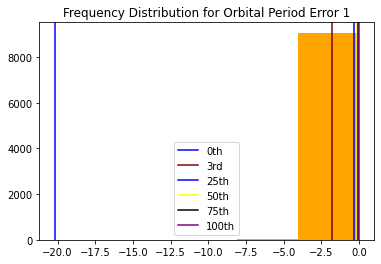

In [29]:
plt.hist(missing_error_values_df["koi_duration_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 3), color = "maroon", label = "3rd")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [30]:
df["koi_duration_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 3), inplace = True)

## Replacing NaN in Transit Depth

### Viewing Frequency Distribution

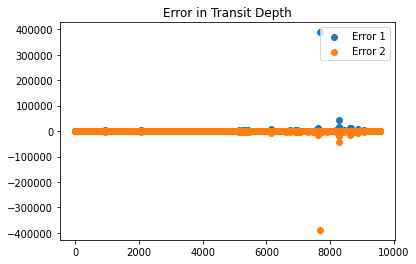

In [31]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_depth_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_depth_err2"].values, label = "Error 2")
plt.title("Error in Transit Depth")
plt.legend()

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


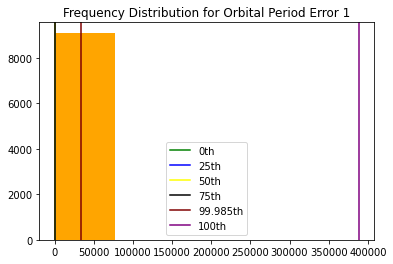

In [32]:
plt.hist(missing_error_values_df["koi_depth_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 99.985), color = "maroon", label = "99.985th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [33]:
df["koi_depth_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 99.985), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


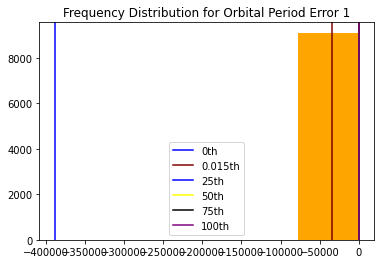

In [34]:
plt.hist(missing_error_values_df["koi_depth_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 0.015), color = "maroon", label = "0.015th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [35]:
df["koi_depth_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 0.015), inplace = True)

## Replacing NaN in Planet Radius

### Viewing Frequency Distribution

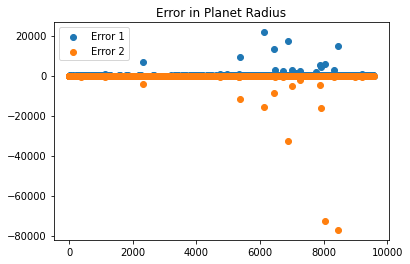

In [36]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_prad_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_prad_err2"].values, label = "Error 2")
plt.title("Error in Planet Radius")
plt.legend()

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


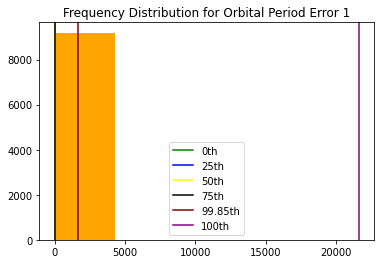

In [37]:
plt.hist(missing_error_values_df["koi_prad_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 99.85), color = "maroon", label = "99.85th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [38]:
df["koi_prad_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 99.85), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


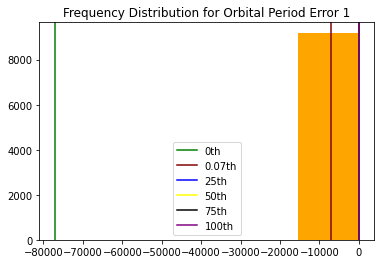

In [39]:
plt.hist(missing_error_values_df["koi_prad_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 0.07), color = "maroon", label = "0.07th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [40]:
df["koi_prad_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 0.07), inplace = True)

## Replacing NaN in  Insolation Flux

### Viewing Frequency Distribution

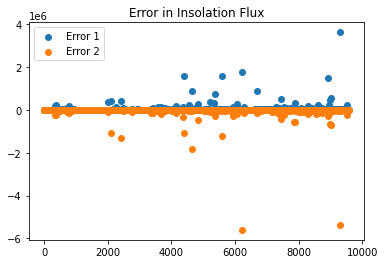

In [41]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_insol_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_insol_err2"].values, label = "Error 2")
plt.title("Error in Insolation Flux")
plt.legend()

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


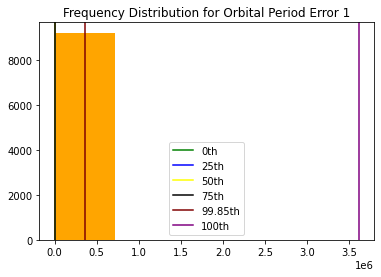

In [42]:
plt.hist(missing_error_values_df["koi_insol_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 99.85), color = "maroon", label = "99.85th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [43]:
df["koi_insol_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 99.85), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


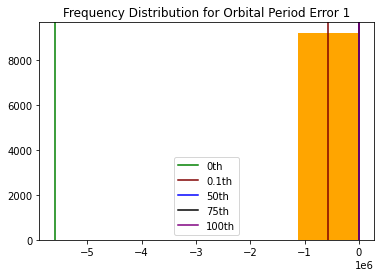

In [44]:
plt.hist(missing_error_values_df["koi_insol_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 0.1), color = "maroon", label = "0.1th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 50), color = "blue", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [45]:
df["koi_insol_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 0.1), inplace = True)

## Replacing NaN in Stellar Effective Temperature

### Viewing Frequency Distribution

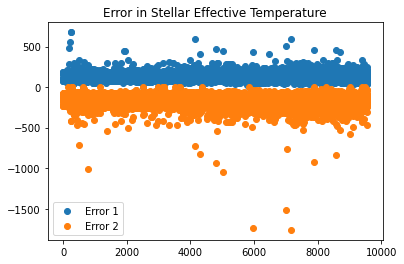

In [46]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_steff_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_steff_err2"].values, label = "Error 2")
plt.title("Error in Stellar Effective Temperature")
plt.legend()

### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


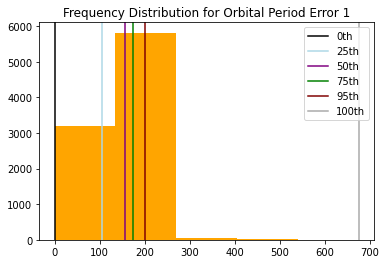

In [47]:
plt.hist(missing_error_values_df["koi_steff_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 0), color = "black", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 25), color = "lightblue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 50), color = "purple", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 75), color = "green", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 95), color = "maroon", label = "95th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 100), color = "darkgrey", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [48]:
df["koi_steff_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 95), inplace = True)

### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


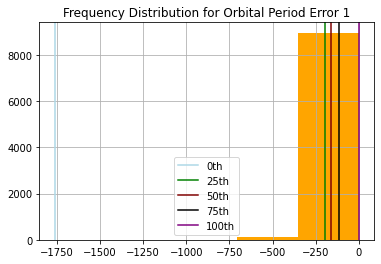

In [49]:
plt.hist(missing_error_values_df["koi_steff_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 0), color = "lightblue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 25), color = "green", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 50), color = "maroon", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.grid()
plt.legend()
plt.show()

In [50]:
df["koi_steff_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 50), inplace = True)

## Replacing NaN in Surface Gravity

### Viewing Frequency Distribution

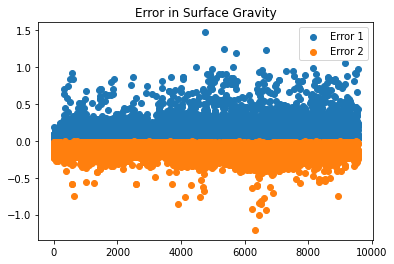

In [51]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_slogg_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_slogg_err2"].values, label = "Error 2")
plt.title("Error in Surface Gravity")
plt.legend()

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


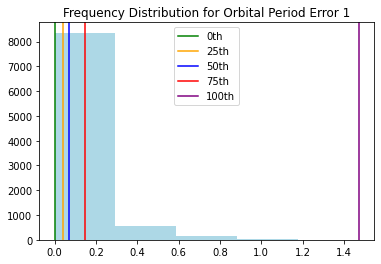

In [52]:
plt.hist(missing_error_values_df["koi_slogg_err1"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 25), color = "orange", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 50), color = "blue", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 75), color = "red", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [53]:
df["koi_slogg_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 75), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


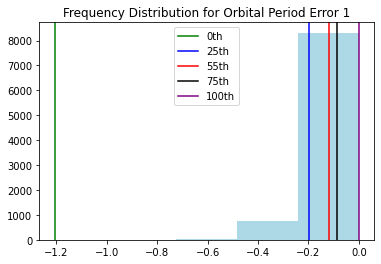

In [54]:
plt.hist(missing_error_values_df["koi_slogg_err2"].values, bins=5, color = "lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 55), color = "red", label = "55th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [55]:
df["koi_slogg_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 55), inplace = True)

## Replacing NaN in Stellar Radius

### Viewing Frequency Distribution

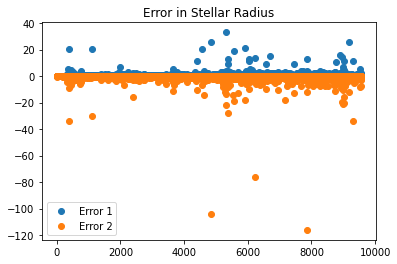

In [56]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_srad_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_srad_err2"].values, label = "Error 2")
plt.title("Error in Stellar Radius")
plt.legend()

#### Positive Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


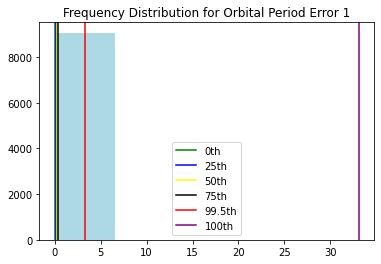

In [57]:
plt.hist(missing_error_values_df["koi_srad_err1"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 99.5), color = "red", label = "99.5th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [58]:
df["koi_srad_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 99.5), inplace = True)

#### Negative Error

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


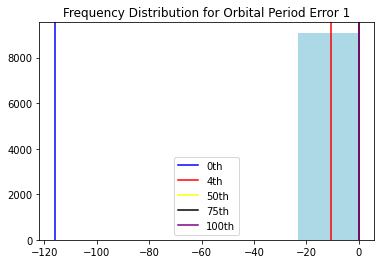

In [59]:
plt.hist(missing_error_values_df["koi_srad_err2"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 0.3), color = "red", label = "4th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [60]:
df["koi_srad_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 0.3), inplace = True)

## Finding Errors in Non-Error Attributes

In [61]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{  'kepler_name': 7270,
   'koi_depth': 363,
   'koi_impact': 363,
   'koi_insol': 321,
   'koi_kepmag': 1,
   'koi_model_snr': 363,
   'koi_prad': 363,
   'koi_score': 1510,
   'koi_slogg': 363,
   'koi_srad': 363,
   'koi_steff': 363,
   'koi_tce_delivname': 346,
   'koi_tce_plnt_num': 346,
   'koi_teq': 363}


Since `kepler_name` is mostly NaN and is a non-essential attriubute, we can drop it.

In [62]:
df.drop(columns = ["kepler_name"], inplace = True)

* kepler_name: Kepler number name in the form "Kepler-N," plus a lower-case letter, identifying the planet. **In general, these numbers are easier to remember than the corresponding KOI or KIC/KepID designations and are intended to clearly indicate a class of objects that have been CONFIRMED or validated as planets**—a step up from the planet candidate designation. Basically, a simpler KEPOI NAME/ID but only for CONFIRMED planets

* koi_score: **A value between 0 and 1 that indicates the confidence in the KOI disposition**. For CANDIDATEs, a higher value indicates more confidence in its disposition, while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition. 

* koi_impact:	Impact Parameter - The sky-projected distance between the center of the stellar disc and the center of the planet disc at conjunction, normalized by the stellar radius. 

* koi_depth: **Transit Depth** - The fraction of stellar flux lost at the minimum of the planetary transit.  

* koi_prad: The **radius** of the planet.

* koi_teq: Approximation for the **equilibrium temperature** of the planet. 

* koi_insol: **Insolation flux is another way to give the equilibrium temperature**. It depends on the stellar parameters (specifically the stellar radius and temperature), and on the semi-major axis of the planet.

* koi_model_snr: **Transit Signal to Noise** - Transit depth normalized by the mean uncertainty in the flux during the transits.

* koi_tce_plnt_num: **TCE Planet Number** federated to the KOI

* koi_tce_delivname: **TCE Delivery Name** corresponding to the TCE data federated to the KOI.

* koi_steff: **Stellar Effective Temperature** - The photospheric temperature of the star.

* koi_kepmag: **Kepler-band magnitude**
* koi_srad: **Stellar Radius** - The photospheric radius of the star 
* koi_slogg: **Stellar Surface Gravity** - The base-10 logarithm of the acceleration due to gravity at the surface of the star. 

In [63]:
df = df[~(df.isnull().sum(axis=1) > int((0.2)*df.shape[1]))]

In [64]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{  'koi_depth': 59,
   'koi_impact': 59,
   'koi_insol': 17,
   'koi_kepmag': 1,
   'koi_model_snr': 59,
   'koi_prad': 59,
   'koi_score': 1206,
   'koi_slogg': 59,
   'koi_srad': 59,
   'koi_steff': 59,
   'koi_tce_delivname': 255,
   'koi_tce_plnt_num': 255,
   'koi_teq': 59}


### Removing NaN in Depth

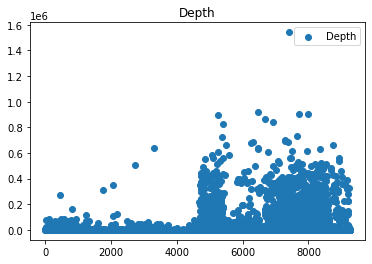

In [65]:
plt.scatter(range(df.shape[0]), df["koi_depth"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


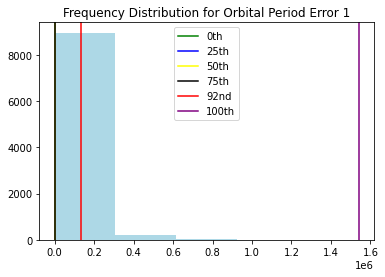

In [66]:
plt.hist(df["koi_depth"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 94), color = "red", label = "92nd")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [67]:
df["koi_depth"].fillna(np.nanpercentile(df["koi_depth"].values, 92), inplace = True)

## Removing NaN in Impact Parameter

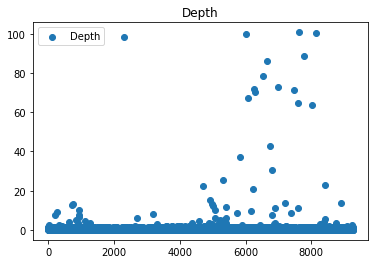

In [68]:
plt.scatter(range(df.shape[0]), df["koi_impact"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


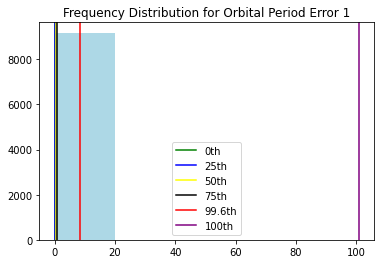

In [69]:
plt.hist(df["koi_impact"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 99.6), color = "red", label = "99.6th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [70]:
df["koi_impact"].fillna(np.nanpercentile(df["koi_impact"].values, 99.6), inplace = True)

## Replacing NaN in Insolation Flux

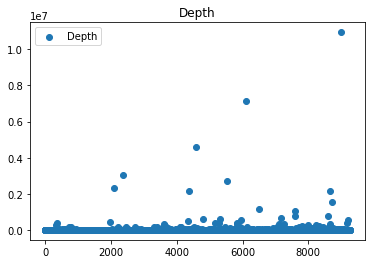

In [71]:
plt.scatter(range(df.shape[0]), df["koi_insol"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


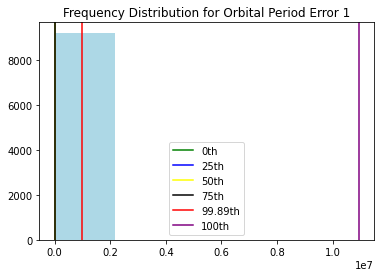

In [72]:
plt.hist(df["koi_insol"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 99.89), color = "red", label = "99.89th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [73]:
df["koi_insol"].fillna(np.nanpercentile(df["koi_insol"].values, 99.89), inplace = True)

## Replacing NaN in Kep Mag

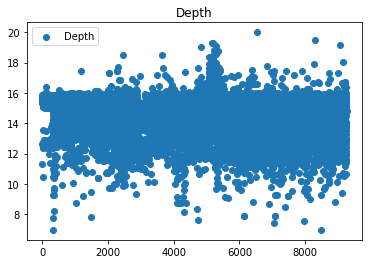

In [74]:
plt.scatter(range(df.shape[0]), df["koi_kepmag"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


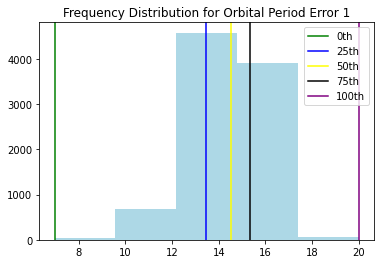

In [75]:
plt.hist(df["koi_kepmag"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [76]:
df["koi_kepmag"].fillna(np.nanpercentile(df["koi_kepmag"].values, 25), inplace = True)

## Replacing NaN in SNR

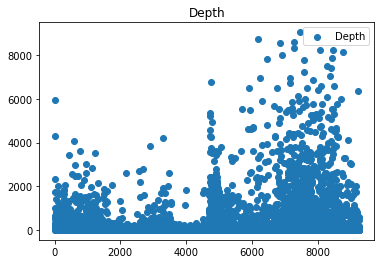

In [77]:
plt.scatter(range(df.shape[0]), df["koi_model_snr"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


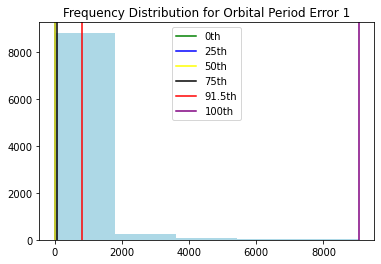

In [78]:
plt.hist(df["koi_model_snr"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 91.5), color = "red", label = "91.5th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [79]:
df["koi_model_snr"].fillna(np.nanpercentile(df["koi_model_snr"].values, 91.5), inplace = True)

## Replacing NaN in Planet Radius

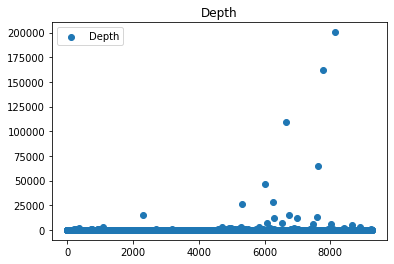

In [80]:
plt.scatter(range(df.shape[0]), df["koi_prad"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


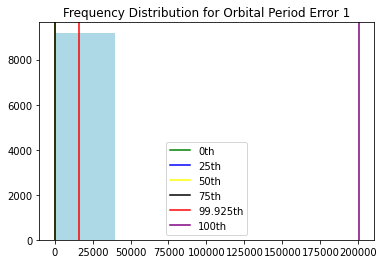

In [81]:
plt.hist(df["koi_prad"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 99.925), color = "red", label = "99.925th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [82]:
df["koi_prad"].fillna(np.nanpercentile(df["koi_prad"].values, 99.925), inplace = True)

## Replacing NaN in Score

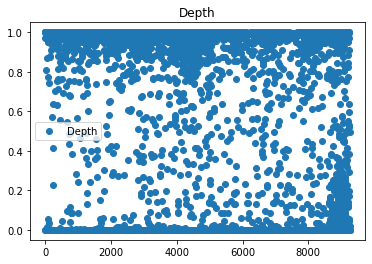

In [83]:
plt.scatter(range(df.shape[0]), df["koi_score"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


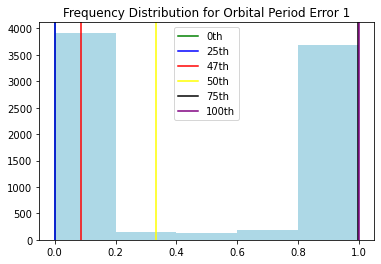

In [84]:
plt.hist(df["koi_score"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 47), color = "red", label = "47th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [85]:
df["koi_score"].fillna(np.nanpercentile(df["koi_score"].values, 47), inplace = True)

## Replacing NaN in Gravitation

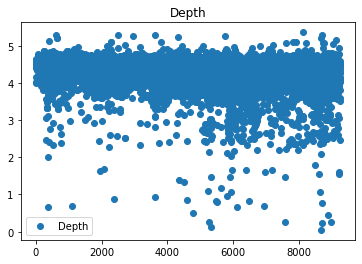

In [86]:
plt.scatter(range(df.shape[0]), df["koi_slogg"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


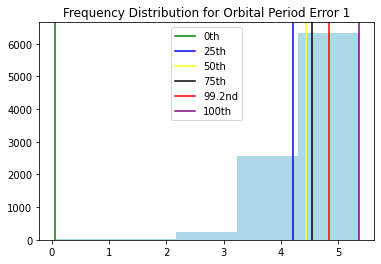

In [87]:
plt.hist(df["koi_slogg"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 99.2), color = "red", label = "99.2nd")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [88]:
df["koi_slogg"].fillna(np.nanpercentile(df["koi_slogg"].values, 99.2), inplace = True)

## Replacing NaN in Stellar Radius

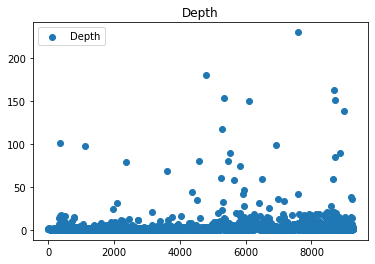

In [89]:
plt.scatter(range(df.shape[0]), df["koi_srad"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


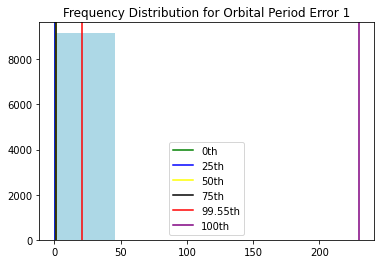

In [90]:
plt.hist(df["koi_srad"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 99.55), color = "red", label = "99.55th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [91]:
df["koi_srad"].fillna(np.nanpercentile(df["koi_srad"].values, 99.55), inplace = True)

## Replacing NaN in Steff

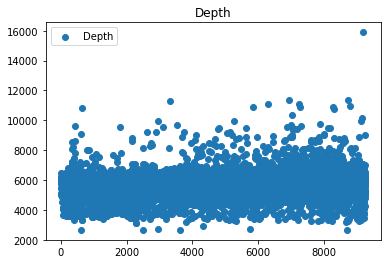

In [92]:
plt.scatter(range(df.shape[0]), df["koi_steff"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


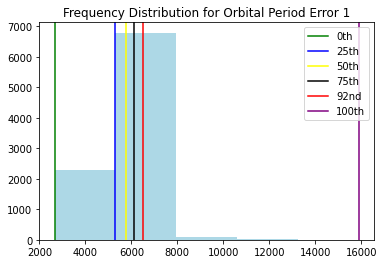

In [93]:
plt.hist(df["koi_steff"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 92), color = "red", label = "92nd")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [94]:
df["koi_steff"].fillna(np.nanpercentile(df["koi_steff"].values, 92), inplace = True)

## Replacing NaN in Equilibrium Temperature

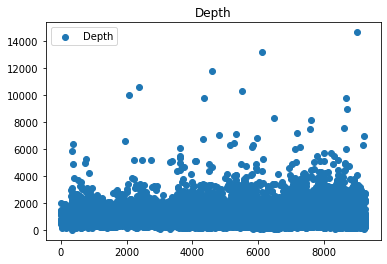

In [95]:
plt.scatter(range(df.shape[0]), df["koi_teq"].values, label = "Depth")
plt.title("Depth")
plt.legend()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


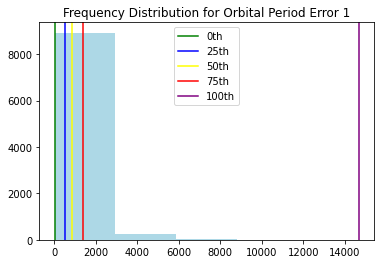

In [96]:
plt.hist(df["koi_teq"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 75), color = "red", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()
plt.show()

In [97]:
df["koi_teq"].fillna(np.nanpercentile(df["koi_teq"].values, 75), inplace = True)

# Re-Counting NaNs

In [98]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{'koi_tce_delivname': 255, 'koi_tce_plnt_num': 255}


# Saving Cleaned Dataset

In [99]:
df.to_csv("[CLEANED]kepler-data.csv")